**predicting Touchdown**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
plt.style.use('seaborn-talk')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/capstone_2_final_preprocessed_data.csv')

In [5]:
data=data.drop('Unnamed: 0',axis=1)

In [6]:
data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,Safety,Onsidekick,PlayType,Passer_ID,PassAttempt,PassOutcome,PassLength,AirYards,YardsAfterCatch,QBHit,PassLocation,InterceptionThrown,Rusher_ID,RushAttempt,RunLocation,RunGap,Receiver_ID,...,RecFumbPlayer,Sack,Challenge.Replay,Accepted.Penalty,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,HomeTeam,AwayTeam,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,No_Score_Prob,Opp_Field_Goal_Prob,Opp_Safety_Prob,Opp_Touchdown_Prob,Field_Goal_Prob,Safety_Prob,Touchdown_Prob,ExPoint_Prob,TwoPoint_Prob,ExpPts,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,14,3,2.0,12:06,13,1626.0,54,PIT,42.0,42.0,10,38,0.0,1.0,TEN,PIT,(12:06) K.Collins pass short left to B.Scaife ...,1,1,0,0,0,0,Pass,00-0003292,1,Complete,Short,1,0,0,left,0,None,0,left,tackle,00-0023612,...,K.Fox,0,0,0,0,7.0,7.0,0.0,-0.0,PIT,TEN,0,None,3,3,3,3,3,0.001336,0.081366,0.000500,0.127569,0.361496,0.003636,0.424096,0.0,0.0,2.922348,-5.607747,-5.607747,0.000000,0.417641,0.582359,0.574091,0.425909,0.582359,-0.156450,-0.156450,0.000000,2009
1,2009-09-10,2009091000,15,3,4.0,10:12,11,1512.0,48,TEN,45.0,45.0,1,9,0.0,1.0,PIT,TEN,(10:12) (Punt formation) D.Sepulveda punts 38 ...,1,0,0,0,0,0,Punt,None,0,Complete,Short,0,0,0,left,0,None,0,left,tackle,None,...,K.Fox,0,0,0,0,7.0,7.0,0.0,-0.0,PIT,TEN,0,None,3,3,3,3,3,0.003482,0.148144,0.001430,0.236492,0.295397,0.006030,0.309024,0.0,0.0,0.958681,0.096593,0.000000,0.000000,0.515547,0.484453,0.549183,0.450817,0.515547,0.033635,0.000000,0.000000,2009
2,2009-09-10,2009091000,23,4,1.0,01:03,2,63.0,57,TEN,34.0,34.0,10,54,0.0,1.0,PIT,TEN,(1:03) (Shotgun) B.Roethlisberger pass deep mi...,1,30,0,0,0,0,Pass,00-0022924,1,Complete,Deep,16,14,0,middle,0,None,0,left,tackle,00-0017162,...,S.Tulloch,0,0,0,0,10.0,10.0,0.0,-0.0,PIT,TEN,0,None,2,2,3,2,3,0.384776,0.023877,0.000103,0.017213,0.308130,0.000673,0.265228,0.0,0.0,2.590006,-2.766193,0.663581,-3.429773,0.798849,0.201151,0.415150,0.584850,0.798849,-0.383699,0.060954,-0.444653,2009
3,2009-09-13,2009091304,7,2,0.0,11:09,12,2469.0,51,MIN,30.0,30.0,0,0,0.0,1.0,CLE,MIN,R.Longwell kicks 70 yards from MIN 30 to CLE 0...,1,27,0,0,0,0,Kickoff,None,0,Complete,Deep,0,0,0,middle,0,None,0,left,tackle,None,...,S.Tulloch,0,0,0,0,3.0,10.0,-7.0,7.0,CLE,MIN,0,None,3,3,3,3,3,0.125554,0.151593,0.005507,0.227161,0.193684,0.003012,0.293488,0.0,0.0,0.585576,0.433691,0.000000,0.000000,0.269452,0.730548,0.283650,0.716350,0.269452,0.014197,0.000000,0.000000,2009
4,2009-09-13,2009091304,7,2,2.0,10:17,11,2417.0,43,CLE,27.0,73.0,8,73,0.0,1.0,CLE,MIN,(10:17) B.Quinn pass short middle to L.Vickers...,1,12,0,0,0,0,Pass,00-0025409,1,Complete,Short,2,10,0,middle,0,None,0,left,tackle,00-0024394,...,S.Tulloch,0,1,0,0,3.0,10.0,-7.0,7.0,CLE,MIN,1,MIN,3,3,3,3,2,0.138326,0.148025,0.003850,0.220793,0.197775,0.003300,0.287931,0.0,0.0,0.618122,1.505180,-0.523761,2.028941,0.273260,0.726740,0.338336,0.661664,0.273260,0.065076,-0.016060,0.081136,2009


This dataset has columns representing various types of probabilities. Since those probability equations are not part of the raw data, I am dropping them.

In [7]:
data.drop(['No_Score_Prob', 'Opp_Field_Goal_Prob', 'Opp_Safety_Prob', 'Opp_Touchdown_Prob', 
         'Field_Goal_Prob','Safety_Prob', 'Touchdown_Prob', 'ExPoint_Prob', 'TwoPoint_Prob', 'ExpPts', 
         'EPA', 'airEPA', 'yacEPA','Home_WP_pre', 'Away_WP_pre', 'Home_WP_post', 'Away_WP_post', 
         'Win_Prob', 'WPA', 'airWPA','yacWPA'],axis=1,inplace=True)

There is also a number of columns that have no significance in touchdowns being scored. These columns will also be dropped.

In [8]:
data.drop(['GameID', 'time', 'Date', 'PlayTimeDiff', 'ydsnet','desc', 'Safety', 'Onsidekick', 'Passer_ID'
,'Rusher_ID', 'Receiver_ID', 'Challenge.Replay', 'Accepted.Penalty','Penalty.Yards','Timeout_Team', 
         'posteam_timeouts_pre', 'HomeTimeouts_Remaining_Pre', 'AwayTimeouts_Remaining_Pre',
         'HomeTimeouts_Remaining_Post', 'AwayTimeouts_Remaining_Post', 'sp'], axis=1, 
          inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['SideofField']=le.fit_transform(data['SideofField'])
data['posteam']=le.fit_transform(data['posteam'])
data['DefensiveTeam']=le.fit_transform(data['DefensiveTeam'])
data['PlayType']=le.fit_transform(data['PlayType'])
data['PassOutcome']=le.fit_transform(data['PassOutcome'])
data['PassLength']=le.fit_transform(data['PassLength'])
data['PassLocation']=le.fit_transform(data['PassLocation'])
data['RunLocation']=le.fit_transform(data['RunLocation'])
data['RunGap']=le.fit_transform(data['RunGap'])
data['RecFumbTeam']=le.fit_transform(data['RecFumbTeam'])
data['RecFumbPlayer']=le.fit_transform(data['RecFumbPlayer'])
data['HomeTeam']=le.fit_transform(data['HomeTeam'])
data['AwayTeam']=le.fit_transform(data['AwayTeam'])
data['Season']=le.fit_transform(data['Season'])

In [10]:
y = data['Touchdown']

X = data.drop('Touchdown', axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify=y)

In [12]:
pip install mlrose

In [13]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from imblearn.over_sampling import SMOTE

X_train_new, y_train_new = SMOTE().fit_sample(X_train, y_train)

print(pd.Series(y_train_new).value_counts())

1    263907
0    263907
dtype: int64


In [14]:
def pred_prob(clf, data): 
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

In [15]:
def find_best_threshold(threshold, fpr, tpr):
    thresh = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(thresh,3))
    return thresh

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

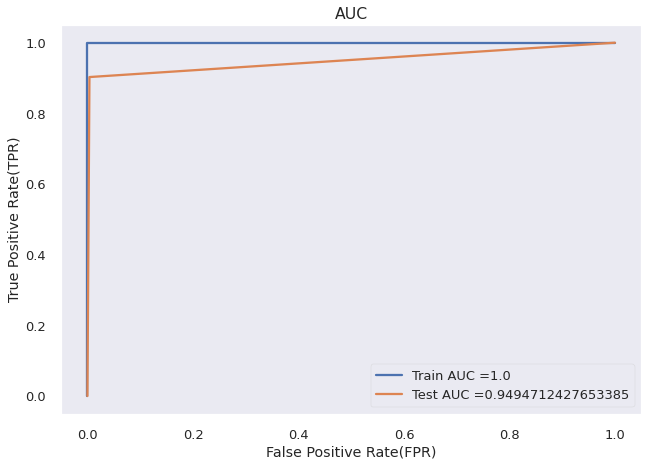

In [16]:
from sklearn.metrics import roc_curve, auc

nb_tfidf = DecisionTreeClassifier()  

nb_tfidf.fit(X_train_new, y_train_new)


y_train_pred = pred_prob(nb_tfidf, X_train_new)    
y_test_pred = pred_prob(nb_tfidf, X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_new, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

Train Data confusion matrix
the maximum value of tpr*(1-fpr) 1.0 for threshold 1.0


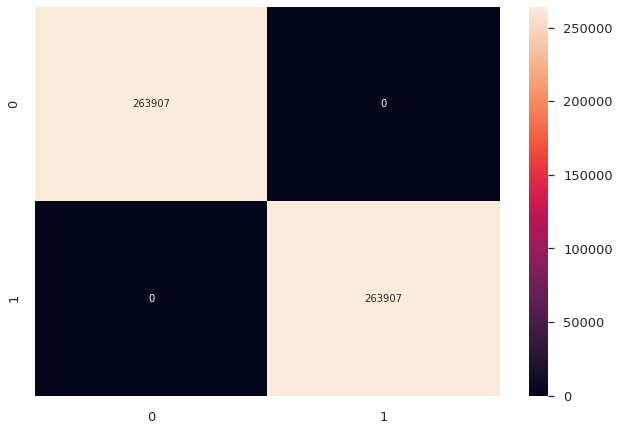

Test data confusion matrix


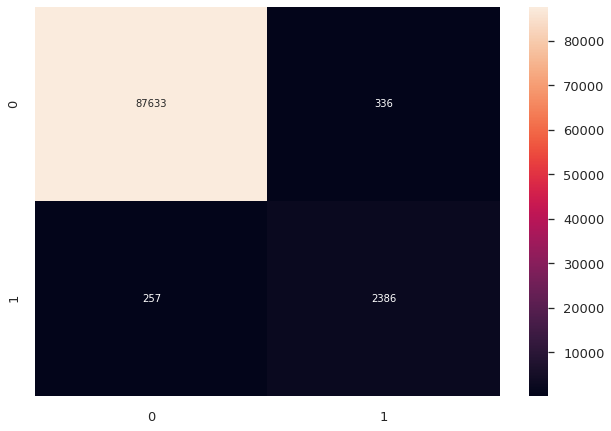

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
print("Train Data confusion matrix")
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm = confusion_matrix(y_train_new, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax)
print("Test data confusion matrix")
fig = plt.figure()
ax = fig.add_subplot(111)
cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax)

In [18]:
def accuracy(X_train, y_train, X_true, y_true, clf):
        
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_true, y_true)

    print(f"Train score = {train_score}")
    print(f"Test score = {test_score}")

In [19]:
accuracy(X_train_new, y_train_new, X_test, y_test, nb_tfidf)

Train score = 1.0
Test score = 0.993455612943098


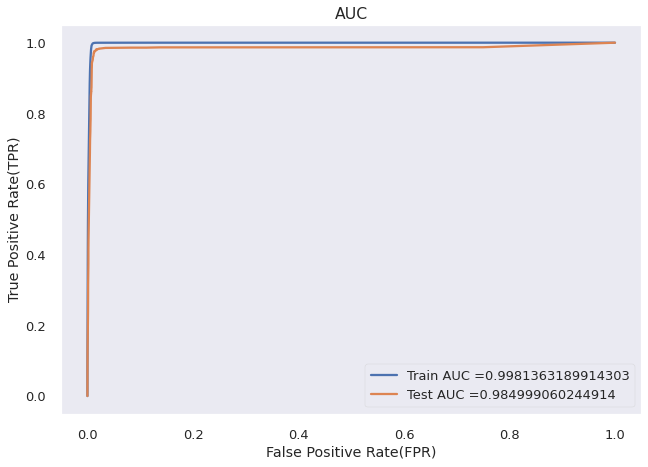

In [21]:
from sklearn.metrics import roc_curve, auc

nb_tfidf = DecisionTreeClassifier(max_depth=10)  

nb_tfidf.fit(X_train_new, y_train_new)


y_train_pred = pred_prob(nb_tfidf, X_train_new)    
y_test_pred = pred_prob(nb_tfidf, X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_new, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

Train Data confusion matrix
the maximum value of tpr*(1-fpr) 0.9878452068291286 for threshold 0.591


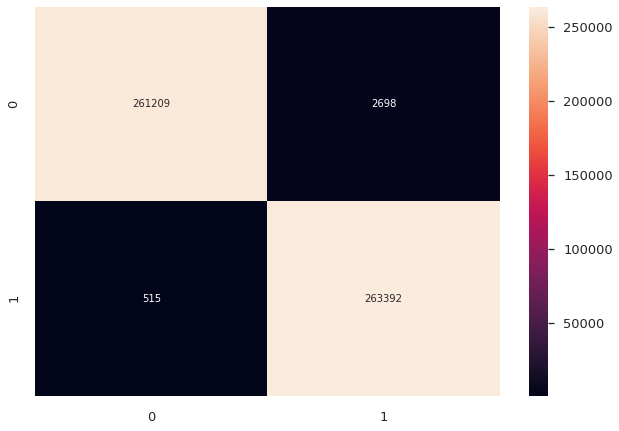

Test data confusion matrix


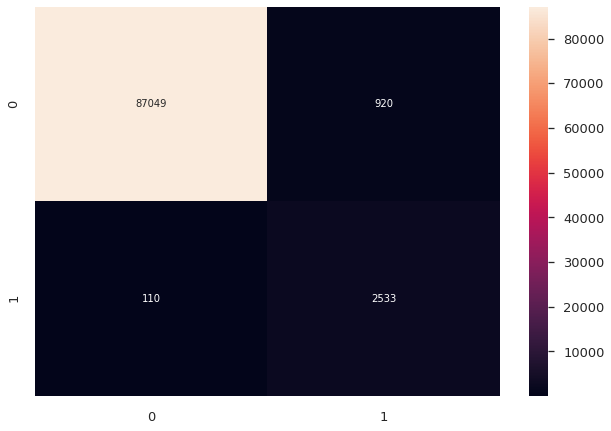

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
print("Train Data confusion matrix")
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm = confusion_matrix(y_train_new, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax)
print("Test data confusion matrix")
fig = plt.figure()
ax = fig.add_subplot(111)
cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm, annot=True, fmt='d')

plt.show(ax)

In [23]:
def accuracy(X_train, y_train, X_true, y_true, clf):
        
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_true, y_true)

    print(f"Train score = {train_score}")
    print(f"Test score = {test_score}")

In [24]:
accuracy(X_train_new, y_train_new, X_test, y_test, nb_tfidf)

Train score = 0.9939126283122464
Test score = 0.9886328521608617
